In [17]:
from utils import *

# Background

| **Source**          | **Metric**    | **Description**                         |
| ------------------- | ------------- | --------------------------------------- |
| Environment Sensors | irr           | Solar Irradiation W/m²                  |
| Environment Sensors | massaPM1      | 1 µm particulate mass                   |
| Environment Sensors | massaPM2      | 2.5 µm particulate mass                 |
| Environment Sensors | massaPM4      | 4 µm particulate mass                   |
| Environment Sensors | massaPM10     | 10 µm particulate mass                  |
| Environment Sensors | numPM1        | 1 µm particulate concentration (#/m³)   |
| Environment Sensors | numPM2        | 2.5 µm particulate concentration (#/m³) |
| Environment Sensors | numPM4        | 4 µm particulate concentration (#/m³)   |
| Environment Sensors | numPM10       | 10 µm particulate concentration (#/m³)  |
| Environment Sensors | tamanho_medio | Average particulate concentration       |
| Environment Sensors | temp          | Enviroment temperature (Celsius )       |
| Environment Sensors | vento_dir     | Wind direction (angles)                 |
| Environment Sensors | vento_vel     | Wind speed (m/s)                        |
| Environment Sensors | rainfall      | Rain precipitation                      |
| Inverter            | P_AC          | Alternate power                         |
| Inverter            | I_AC          | Alternate current                       |
| Inverter            | I_DC          | Direct current                          |
| Inverter            | V_AC          | Alternate voltage                       |
| Inverter            | V_DC          | Direct voltage                          |
| Inverter            | IRR           | Irradiation W/m²                        |


# Data Engineering stuff


In [18]:
# electrical data
el_files = glob.glob('./data/photovoltaic_powerplant/electrical_data/*.csv')
el_df = pd.concat([pd.read_csv(
    f, dtype={'dia_mes_ano': object, 'hora_minuto': object}) for f in el_files], ignore_index=True)

# environmental data
env_files = glob.glob(
    './data/photovoltaic_powerplant/environmental_data/*.csv')
env_df = pd.concat([pd.read_csv(
    f, dtype={'dia_mes_ano': object, 'hora_minuto': object}) for f in env_files], ignore_index=True)

In [19]:
# dataframes list
dfs = [el_df, env_df]

for df in dfs:
    # create a datetime column for each dataframe
    df['datetime'] = pd.to_datetime(
        df['dia_mes_ano'] + df['hora_minuto'], format='%Y%m%d%H%M%S', errors='coerce')
    # print errors
    print(f'Dataframe length: {len(df)}')
    print('Number of rows with converting errors:',
          len(df[df['datetime'].isnull()]))
    # drop original columns from both dfs
    df.drop({'dia_mes_ano', 'hora_minuto'}, 1, inplace=True)

Dataframe length: 198241
Number of rows with converting errors: 0
Dataframe length: 172735
Number of rows with converting errors: 69


In [20]:
# drop errors as low percentage on environment dataset
env_df = env_df[env_df['datetime'].notnull()]

Since we're interesting primarly on eletrical data, we're going to left join electrical data with environment data on 'datetime' column. Let's set Indicator=True.


In [21]:
# merge dataframes on datetime column
df = el_df.merge(env_df, on='datetime', how='left', indicator=True)

In [22]:
# just a quick renaming
df.rename(columns={
    'irr': 'solar_irradiation',
    'massaPM1': 'pm1',
    'massaPM2': 'pm2',
    'massaPM4': 'pm4',
    'massaPM10': 'pm10',
    'numPM1': 'pc1',
    'numPM2': 'pc2',
    'numPM4': 'pc4',
    'numPM10': 'pc10',
    'tamanho_medio': 'avg_pc',
    'vento_dir': 'wind_direction',
    'vento_vel': 'wind_speed',
    'P_AC': 'p_ac',
    'I_AC': 'i_ac',
    'I_DC': 'i_dc',
    'V_AC': 'v_ac',
    'V_DC': 'v_dc',
    'IRR': 'i_irradiation',
}, inplace=True)

In [23]:
# extracting month
df['month'] = df['datetime'].apply(lambda x: x.strftime('%B'))
# extracting day hour
df['hour'] = df['datetime'].apply(lambda x: x.strftime('%H'))
# convert to float type
df['wind_direction'] = df['wind_direction'].astype(float)

## A further look to the features distribution


In [24]:
env_features = ['solar_irradiation', 'pm1', 'pm2', 'pm4', 'pm10', 'pc1', 'pc2',
                'pc4', 'pc10', 'avg_pc', 'temp', 'wind_direction', 'wind_speed', 'rainfall']
el_features = ['p_ac', 'i_ac', 'i_dc', 'v_ac', 'v_dc', 'i_irradiation']

In [25]:
# environment features
df[env_features].describe()

,solar_irradiation,pm1,pm2,pm4,pm10,pc1,pc2,pc4,pc10,avg_pc,temp,wind_direction,wind_speed,rainfall
count,145312.000000,146230.000000,146230.000000,146230.000000,146230.000000,146230.000000,146230.000000,146230.000000,146230.000000,146230.000000,146230.000000,146230.000000,146230.000000,145312.000000
mean,187.289677,3.828483,0.136686,0.007020,0.001121,31.571589,0.096759,0.001421,0.000271,0.456314,22.829985,131.648909,8.644573,0.522916
std,322.187199,5.734220,0.539483,0.367483,0.058852,47.240890,0.549233,0.065997,0.010779,0.030755,26.579038,95.658153,8.662620,3.733492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.370000,-127.000000,0.000000,0.000000,0.000000
25%,0.000000,1.690000,0.060000,0.000000,0.000000,13.960000,0.040000,0.000000,0.000000,0.440000,23.120000,45.000000,1.330000,0.000000
50%,0.000000,2.850000,0.100000,0.000000,0.000000,23.530000,0.070000,0.000000,0.000000,0.450000,26.380000,135.000000,6.650000,0.000000
75%,256.750000,4.510000,0.150000,0.000000,0.000000,37.220000,0.100000,0.000000,0.000000,0.470000,31.380000,180.000000,13.300000,0.000000
max,1536.510000,206.960000,141.240000,102.650000,16.440000,1707.490000,149.230000,18.420000,2.990000,1.630000,42.190000,335.000000,150.290000,89.500000


25th quantile: 23.12 
75h quantile: 31.38 
IQR: 8.259999999999998
Cut-Off Threshold: 12.389999999999997             
Lower Bound: 10.730000000000004
Upper Bound: 43.769999999999996
# of outliers: 4367
% of outliers: 0.02202874279286323


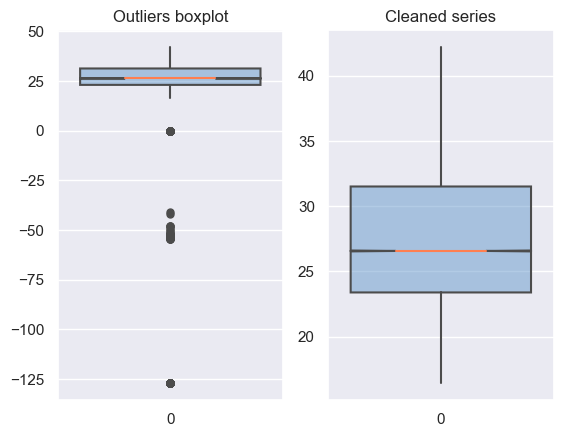

In [26]:
# replace outliers with NaN values
df = PreProcessor.outliers(df, 'temp', 'replace_with_na')

## _A Spinoff - Handling NA Values_


In [27]:
print(
    '% of rows with missing values from merge:',
    round(len(df.query("_merge == 'left_only'"))/len(df), 4)
)

% of rows with missing values from merge: 0.2624


26 % of rows with missing values it's a lot! More than $\frac{1}{4}$ of the entire dataset does not contains informations from environmental sensors.


In [28]:
# temporary dataframe
df_temp = df.copy()
# sort values by datetime
df_temp.sort_values('datetime', ascending=True, inplace=True)
# create a date column
df_temp['date'] = df_temp['datetime'].dt.date
# # let's have a look to days with missing values
na_days = df_temp[df_temp['pm1'].isnull()].groupby('date', as_index=False)['pm1'].apply(
    lambda x: x.isnull().sum()).sort_values('pm1', ascending=False)
na_days

,date,pm1
56,2019-12-05,1440
78,2019-12-27,1438
101,2020-01-19,1382
10,2019-10-20,1379
53,2019-12-02,1199
...,...,...
118,2020-02-05,2
0,2019-10-04,2
1,2019-10-05,1
3,2019-10-13,1


### Classical methods


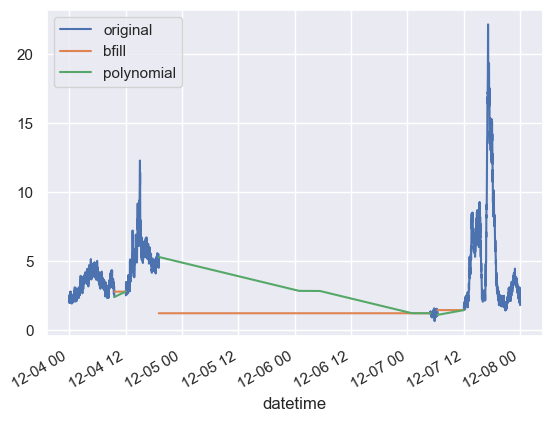

In [29]:
def imputing_values_plot(df, feature, startdate, enddate):

    #
    imp = df[['datetime', feature]]
    imp.rename(columns={feature: 'original'}, inplace=True)
    # backfill imputation
    imp['bfill'] = imp['original'].fillna(method='bfill')
    # polynomial interpolation
    imp['polynomial'] = imp['original'].interpolate(
        method='polynomial', order=1)

    # list of methods used
    methods = imp.columns.to_list()
    methods.remove('original')
    methods.remove('datetime')

    # replace with NaN for existing values
    for method in methods:
        imp[method] = (imp[method]).where(imp['original'].isnull(), np.NaN)

    # set datetime as index
    imp.set_index('datetime', inplace=True)
    # plot it
    imp[startdate:enddate].plot()

    return


imputing_values_plot(df_temp, 'pm1', '2019-12-04', '2019-12-07')

### Mice imputation


In [43]:
# # let's have a look to days without missing values
wna_days = list(
    set(df_temp['date'].to_list()) - set(na_days['date'].to_list())
)
wna_days.sort()
wna_days

[datetime.date(2019, 10, 6),
 datetime.date(2019, 10, 7),
 datetime.date(2019, 10, 8),
 datetime.date(2019, 10, 9),
 datetime.date(2019, 10, 10),
 datetime.date(2019, 10, 12)]

<Axes: xlabel='datetime'>

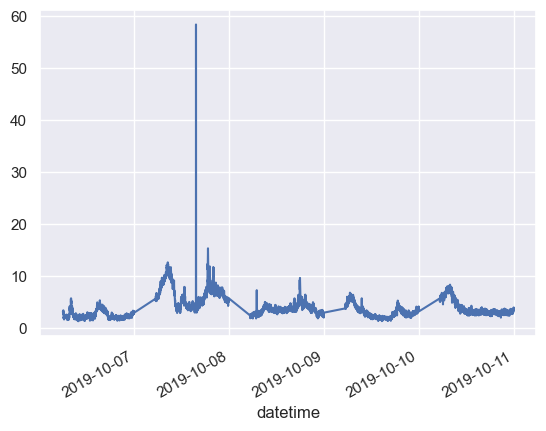

In [44]:
# let's visualize data without missing values
tsdate, tedate = '2019-10-06', '2019-10-10'
df_temp.set_index('datetime')[tsdate:tedate]['pm1'].plot()

In [48]:
# test df for imputation with non missing rows
# selecting up to 2019-10-10
df_timp = df_temp[df_temp['date'].isin(wna_days[0:-1])]


# replace last two dates with NaN values
df_timp.loc[df_timp[df_timp['date'].isin(wna_days[3:5])][env_features].index,
            env_features] = np.nan

# categorical columns
cat_cols = ['month', 'hour', 'date', '_merge', 'datetime']

# tester
tester = df_timp.drop(cat_cols, 1)

#### Basic setup


In [64]:
# create imputation kernel
kds = mf.ImputationKernel(
    tester,
    datasets=4,
    save_all_iterations=True,
    random_state=2023)

# run cross-validation for parameters tuning
op_params, losses = kds.tune_parameters(dataset=0,
                                        optimization_steps=5)

# Run the MICE algorithm for 2 iterations with best parameters
kds.mice(2, variable_parameters=op_params)

{17: {'boosting': 'gbdt', 'num_iterations': 250, 'max_depth': 8, 'num_leaves': 7, 'min_data_in_leaf': 120, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.9389136919254784, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.9915823541344022, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'learning_rate': 0.02, 'cat_smooth': 12.129312323538176}, 16: {'boosting': 'gbdt', 'num_iterations': 250, 'max_depth': 8, 'num_leaves': 19, 'min_data_in_leaf': 53, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.7087916442589492, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.39401380335597125, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'learning_rate': 0.02, 'cat_smooth': 10.046305644948669}, 15: {'boosting': 'gbdt', 'num_iterations': 250, 'max_depth': 8, 'num_leaves': 6, 'min_data_in_leaf': 190, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.8886256974294405, 

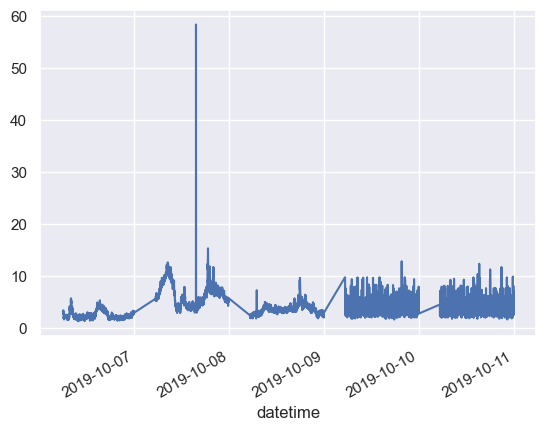

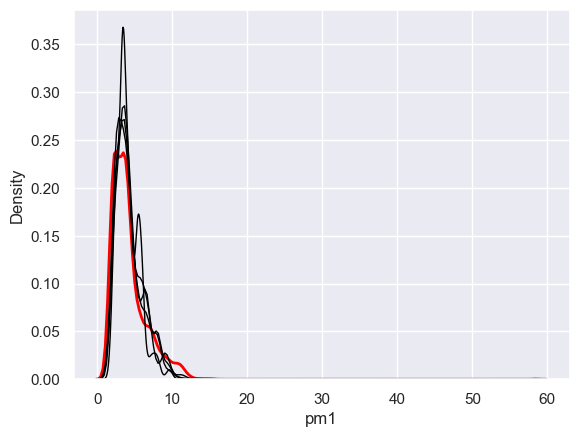

In [85]:
dataset, feature = 0, 'pm1'
# select a dataset and visualize it
imp_data = kds.complete_data(dataset)
# add categorical columns
imp_data = pd.concat([imp_data, df_timp[cat_cols]], 1)

# plot imputed data and distributions
imp_data.set_index('datetime')[feature].plot()
kds.plot_imputed_distributions(variables=[feature])